In [9]:
import numpy as np
import matplotlib.pyplot as plt

# 13.2 Hidden Markov Models

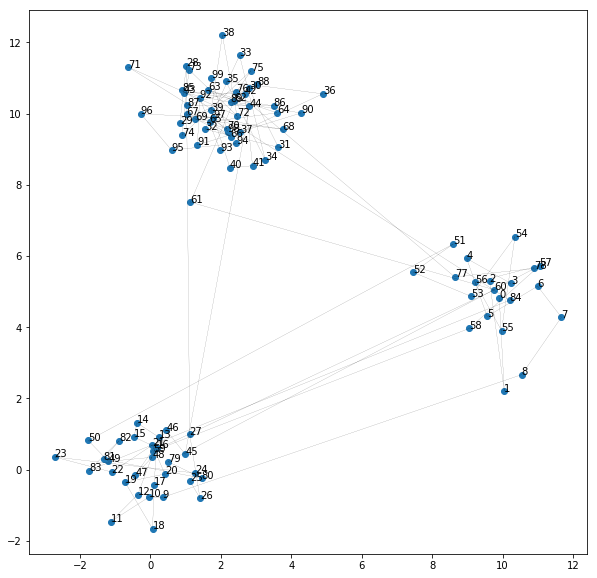

In [10]:
initial_prob = np.ones(3) / 3
transition_prob = np.array([[.9, .05, .05], [.05, .9, .05], [.05, .05, .9]])
means = np.array([[0, 0], [2, 10], [10, 5]])
covs = np.asarray([np.eye(2) for _ in range(3)])
precisions = np.linalg.inv(covs)
ndims = means.shape[1]
n_hidden = 3

n = 100
hidden_state = np.random.choice(n_hidden,  p = initial_prob)
seq = []
while len(seq) < n:
    x = np.random.multivariate_normal(means[hidden_state], covs[hidden_state], 1)
    seq.extend(x)
    hidden_state = np.random.choice(n_hidden, p = transition_prob[hidden_state])
    
seq = np.asarray(seq)
plt.figure(figsize=(10, 10))
plt.scatter(seq[:, 0], seq[:, 1])
plt.plot(seq[:, 0], seq[:, 1], "k", linewidth=0.1)
for i, p in enumerate(seq):
    plt.annotate(str(i), p)

In [11]:
def likelihood(X, means, precisions, covs, ndims):
    diff = X[:, None, :] - means
    exponents = np.sum(np.einsum('nki, kij->nkj', diff, precisions) * diff, axis= -1)
    return np.exp(-.5 * exponents) / np.sqrt(np.linalg.det(covs) * (2 * np.pi) ** ndims)

def maximize(seq, p_hidden, p_transition):
    initial_prob = p_hidden[0] / np.sum(p_hidden[0])
    transition_prob = np.sum(p_transition, axis=0)/np.sum(p_transition, axis=(0,2))
    Nk = np.sum(p_hidden, axis=0)
    means = (seq.T @ p_hidden/Nk).T
    diffs = seq[:, None, :] - means
    covs = np.einsum('nki,nkj->kij', diffs, diffs * p_hidden[:, :, None]) / Nk[:, None, None]
    precisions = np.linalg.inv(covs)
    return initial_prob, transition_prob, means, covs, precisions

def expect(seq, means, precisions, covs, ndims,  n_hidden, initial_prob, transition_prob):
    seq_likelihood = likelihood(seq, means, precisions, covs, ndims)
    f = initial_prob * seq_likelihood[0]
    constant = [f.sum()]
    forward = [f/f.sum()]
    for like in seq_likelihood[1:]:
        f = forward[-1] @ transition_prob * like
        constant.append(f.sum())
        forward.append(f/f.sum())
    forward = np.asarray(forward)
    constant = np.asarray(constant)

    backward = [np.ones(n_hidden)]
    for like, c in zip(seq_likelihood[-1:0:-1], constant[-1:0:-1]):
        backward.insert(0, transition_prob @ (like * backward[0]) / c)
    backward = np.asarray(backward)

    p_hidden = forward * backward
    p_transition = transition_prob * seq_likelihood[1:, None, :] * backward[1:, None, :] * forward[:-1, :, None]
    return p_hidden, p_transition


In [117]:
iter_max = 100

for i in range(iter_max):
    p_hidden, p_transition = expect(seq, means, precisions, covs, ndims, n_hidden, initial_prob, transition_prob)
    initial_prob, transition_prob, means, covs, precisions = maximize(seq, p_hidden, p_transition)

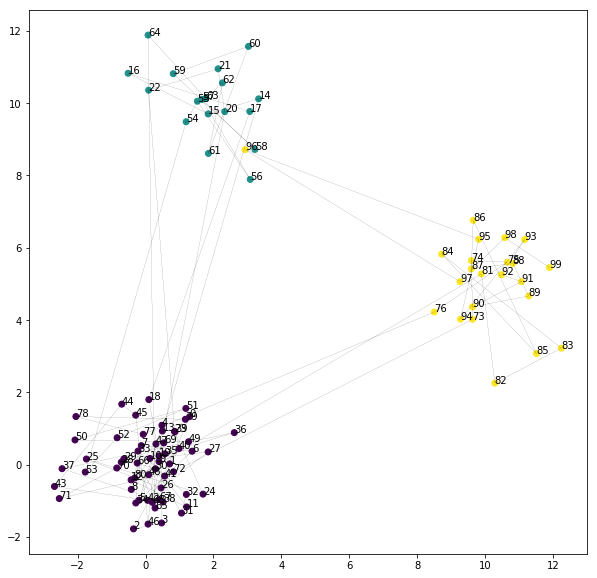

In [123]:
plt.figure(figsize=(10, 10))
plt.scatter(seq[:, 0], seq[:, 1], c=np.argmax(p_hidden, axis=-1))
plt.plot(seq[:, 0], seq[:, 1], "k", linewidth=0.1)
for i, p in enumerate(seq):
    plt.annotate(str(i), p)

# 13.3 Linear Dynamical Systems

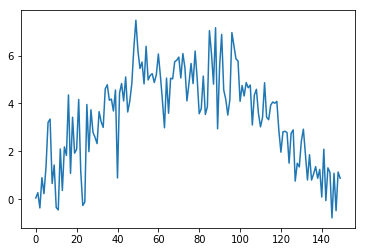

In [5]:
observed_sequence = np.concatenate(
    (np.arange(50)[:, None] * 0.1 + np.random.normal(size=(50, 1)),
     np.random.normal(loc=5., size=(50, 1)),
     5 - 0.1 * np.arange(50)[:, None] + np.random.normal(size=(50, 1))), axis=0)
plt.plot(observed_sequence)
plt.show()

In [12]:
system = np.array([[1., 1.], [0., 1.]])
cov_system = np.eye(2) * .001
measure = np.array([[1., 0.]])
cov_measure = np.eye(1)*10
mu0 = np.zeros(2)
P0 = np.eye(2) * 100

hidden_mean = [mu0]
hidden_cov = [P0]
hidden_cov_predicted = [None]

for obs in observed_sequence:
#     predict hidden state at current step given estimate at previous step
    mu_prev, cov_prev = hidden_mean[-1], hidden_cov[-1]
    mu = system @ mu_prev
    cov = system@cov_prev@system.T + cov_system
    hidden_mean.append(mu)
    hidden_cov.append(cov)
    hidden_cov_predicted.append(np.copy(cov))
    
#     bayesian update of current estimate given current observation
    mu, cov = hidden_mean[-1], hidden_cov[-1]
    innovation = obs - measure @ mu
    cov_innovation = cov_measure + measure @ cov @ measure.T
    kalman_gain = np.linalg.solve(cov_innovation, measure @ cov).T
    mu += kalman_gain @ innovation
    cov -= kalman_gain @ measure @ cov

mean_sequence = np.asarray(hidden_mean[1:])
cov_sequence = np.asarray(hidden_cov[1:])

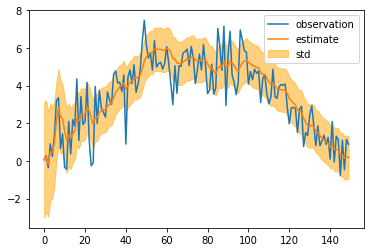

In [13]:
result_mean = mean_sequence[:,0]
result_std = np.sqrt(cov_sequence[:, 0, 0])
plt.plot(observed_sequence, label="observation")
plt.plot(result_mean, label="estimate")
plt.fill_between(np.arange(len(result_mean)), result_mean - result_std, result_mean + result_std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

In [14]:
system = np.array([[1., 1.], [0., 1.]])
cov_system = np.eye(2) * .001
measure = np.array([[1., 0.]])
cov_measure = np.eye(1)*10
mu0 = np.zeros(2)
P0 = np.eye(2) * 100

hidden_mean = [mu0]
hidden_cov = [P0]
hidden_cov_predicted = [None]

smoothed_until = -1
smoothing_gain = [None]

for obs in observed_sequence:
#     predict hidden state at current step given estimate at previous step
    mu_prev, cov_prev = hidden_mean[-1], hidden_cov[-1]
    mu = system @ mu_prev
    cov = system@cov_prev@system.T + cov_system
    hidden_mean.append(mu)
    hidden_cov.append(cov)
    hidden_cov_predicted.append(np.copy(cov))
    
#     bayesian update of current estimate given current observation
    mu, cov = hidden_mean[-1], hidden_cov[-1]
    innovation = obs - measure @ mu
    cov_innovation = cov_measure + measure @ cov @ measure.T
    kalman_gain = np.linalg.solve(cov_innovation, measure @ cov).T
    mu += kalman_gain @ innovation
    cov -= kalman_gain @ measure @ cov

while smoothed_until != -len(hidden_mean):
    mean_smoothed_next = hidden_mean[smoothed_until]
    cov_smoothed_next = hidden_cov[smoothed_until]
    cov_pred_next = hidden_cov_predicted[smoothed_until]
    
    smoothed_until -= 1
    mean = hidden_mean[smoothed_until]
    cov = hidden_cov[smoothed_until]
    gain = np.linalg.solve(cov_pred_next, system @ cov).T
    mean += gain @ (mean_smoothed_next - system @ mean)
    cov += gain @ (cov_smoothed_next - cov_pred_next) @ gain.T
    smoothing_gain.insert(0, gain)
    
mean_sequence = np.asarray(hidden_mean[1:])
cov_sequence = np.asarray(hidden_cov[1:])


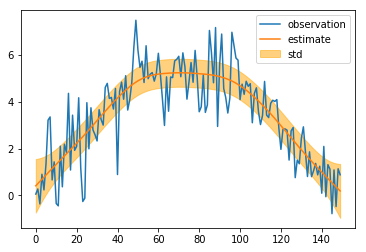

In [15]:
result_mean = mean_sequence[:,0]
result_std = np.sqrt(cov_sequence[:, 0, 0])
plt.plot(observed_sequence, label="observation")
plt.plot(result_mean, label="estimate")
plt.fill_between(np.arange(len(result_mean)), result_mean - result_std, result_mean + result_std, color="orange", alpha=0.5, label="std")
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

# 13.3.4 Particle filters